# Natural Language Processing for the Fake News Challenge

## Main Imports

In [15]:
import time
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Set up the data for preprocessing
### Load and sample the data

In [16]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [17]:
body_data.sample(10)

,Body ID,articleBody
865,1305,Cuban dissidents and Cuban-American media are ...
1624,2444,A luxe Viking island owned by the world's sixt...
9,13,A SOLDIER has been shot at Canada’s National W...
183,288,Islamic State (IS) fighters may have captured ...
177,280,ISLAMIC State group jihadists are being traine...
936,1403,Reports that Comcast will deny Internet servic...
1623,2443,There have been reports of predator drones bei...
47,72,The move comes after the actor's talks with Fo...
426,645,The Apple Watch will not be an accessory for y...
922,1379,The video texting service Glide has verified t...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [18]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
26566,1498,A prominent religious scholar in Saudi Arabia ...,Saudi Arabia Cleric Issues Fatwa Against Build...,discuss,related
748,34,"Abdel-Majed Abdel Bary, who went by the rap na...",Boko Haram ceasefire ignored as violence flare...,unrelated,unrelated
11987,720,DNA tests have confirmed that a daughter and a...,Lebanon detains wife and son of Al-Baghdadi,agree,related
1155,45,Zack Snyder recently unveiled an official phot...,Apple-HBO Deal Seen Launching Web-only Apple T...,unrelated,unrelated
8059,511,The leaked video of Georgy Myakinkin's protest...,Video showing American journalist beheaded bel...,unrelated,unrelated
27451,1545,Macaulay Culkin has once again died — at least...,Predator Drone Reportedly Sighted Circling Raq...,unrelated,unrelated
3530,206,Two U.S. officials say they believe American j...,Nigeria: hopes for return of kidnapped schoolg...,unrelated,unrelated
31909,1786,A British man who went to fight against Islami...,Audio captured at time of Michael Brown shooti...,unrelated,unrelated
35805,1921,The man who jumped the White House fence this ...,Pentagon: Airstrike killed terror leader in So...,unrelated,unrelated
13821,825,Defense Secretary Chuck Hagel said on Saturday...,"US hostage 'murdered' by militants in Yemen, s...",discuss,related


### Splitting the dataset into train and validation sets

In [19]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
32401,Alleged Ottawa gunman: What we know so far abo...,New York City continues to seek ways to cut do...
49373,NASA Confirms Earth Will Experience 6 Days of ...,"Anna Wintour, editor-in-chief on Vogue magazin..."
12742,Ottawa investigates reports that Isis has capt...,"Gill Rosenberg, the Canadian Israeli volunteer..."
8616,Lebanon 'holding IS leader's daughter and ex-w...,"A homeless man was given a hundred dollars, an..."
43948,One gunman killed in shooting on Parliament Hi...,Parliament Hill's Centre Block is in lockdown ...
25128,Fence Jumper Made It Deeper Into the White Hou...,Could a newly released audio provide more clue...
17249,ISIS Appears To Behead American Photojournalis...,"Islamic State, in video titled ""A Message to A..."
40542,Who Is Michael Zehaf-Bibeau? Ottawa Shooter Su...,"Vice founder Shane Smith, with something that ..."
43702,Dog Found Abandoned With Suitcase Filled With ...,The woman also detained is believed to be al-B...
38430,Norfolk Man Pays £300 For His Constipated Gold...,A married TV actor who met a young woman and k...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [20]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [21]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=50, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=50, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 100)
Val size:  (9995, 100)


## Evaluation Metrics

### Confusion Matrix

In [22]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [23]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [24]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7333466743377443
validation score: 0.7231615807903952


### Support Vector Machine Classifier

In [25]:
start = time.time()
model = SVC()
model.fit(train, y_train)
end = time.time()
print(end - start, "seconds")

351.15018010139465 seconds


              precision    recall  f1-score   support

     related       0.93      0.72      0.81      2767
   unrelated       0.90      0.98      0.94      7228

    accuracy                           0.91      9995
   macro avg       0.91      0.85      0.88      9995
weighted avg       0.91      0.91      0.90      9995



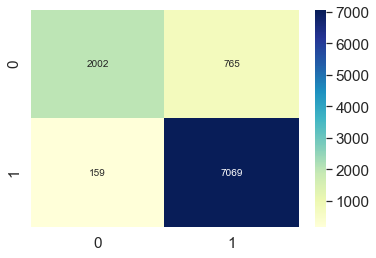

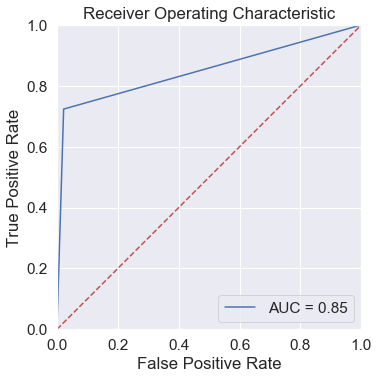

In [26]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)

In [27]:
# training an SVM on TF-IDF features
# Define the parameters to tune

start = time.time()
parameters = {
    'C': [1, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
end = time.time()
print(end - start, "seconds")

3860.5856041908264 seconds


              precision    recall  f1-score   support

     related       0.90      0.87      0.89      2767
   unrelated       0.95      0.96      0.96      7228

    accuracy                           0.94      9995
   macro avg       0.93      0.92      0.92      9995
weighted avg       0.94      0.94      0.94      9995



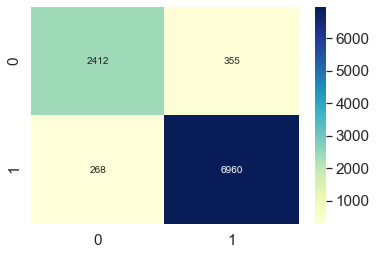

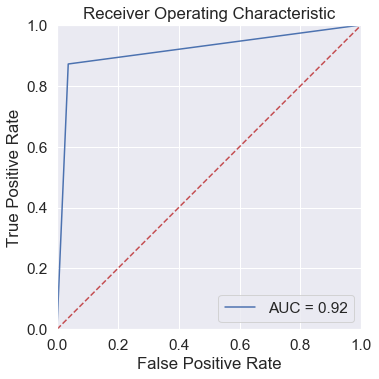

In [28]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)